In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from epiweeks import Week
from statsmodels.tools.eval_measures import rmse
from src.housing_scripts import *
from src.time_scripts import *

pd.options.display.max_columns = None
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## READ CSV INTO DATAFRAME

In [3]:
master=pd.read_csv('clean_master.csv',header=0, index_col=0)

## IMPORT PROPHET

In [4]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from src.time_scripts import *

Separate into property type and city subsets

In [5]:
master, sfr_master, condo_master, town_master, sm_data, bh_data, sl_data = forecasting_datasets_setup(master) 

## Split into Weeks
+ plot weekly unit closed count

In [6]:
def week_split_count(df):
    w = df[['CloseDate','ClosePrice']]
    w['week']=pd.to_datetime(w.CloseDate).apply(lambda x: '{}'.format(x.week))
    w['year']=pd.to_datetime(w.CloseDate).apply(lambda x: '{}'.format(x.year))
    ww = w[['week','year']]
    ww.week=ww.week.apply(int)
    ww.year=ww.year.apply(int)
    ww=ww[ww.week!=53]
    ww['enddate'] = ww.apply(lambda row: pd.to_datetime(Week(row.year, row.week, 'iso').enddate()),axis=1)
    w['ds'] = ww['enddate']
    w=w[['ds','ClosePrice']]
    w.rename(columns={'ClosePrice':'y'},inplace=True)
    w=w.groupby('ds').count()
    w.reset_index(inplace=True)
    w['ds'] = w['ds'].apply(lambda x: pd.to_datetime(x))
    return w

def day_split_count(df):
    w = df[['CloseDate','ClosePrice']]
    w['ClosePrice'] = w['ClosePrice'].apply(lambda x: np.log(x))
    w['CloseDate']=pd.to_datetime(w.CloseDate).apply(lambda x: '{}-{}-{}'.format(x.year,x.month,x.day))
    w.rename(columns={'ClosePrice':'y','CloseDate':'ds'},inplace=True)
    w=w.groupby('ds').count()
    w.reset_index(inplace=True)
    w['ds'] = w['ds'].apply(lambda x: pd.to_datetime(x))
    return w

def time_plot(df):
    sns.lineplot(x='ds',y='y',data=df)
    
def time_series_sale_count(df):
    ts = df[['CloseDate','ClosePrice']]
    ts.CloseDate = pd.to_datetime(ts.CloseDate).apply(lambda x: '{}-{}'.format(x.year,x.month))
    ts.CloseDate = pd.to_datetime(ts.CloseDate)
    ts = ts.groupby('CloseDate').count().sort_values('CloseDate')
    ts = ts.reset_index()
    ts.rename(columns={'CloseDate':'ds','ClosePrice':'y'},inplace=True)
    return ts

## Data is formatted for modeling

In [7]:
# data by city
sm_count_weekly_data=week_split_count(sm_data)
bh_count_weekly_data=week_split_count(bh_data)
sl_count_weekly_data=week_split_count(sl_data)

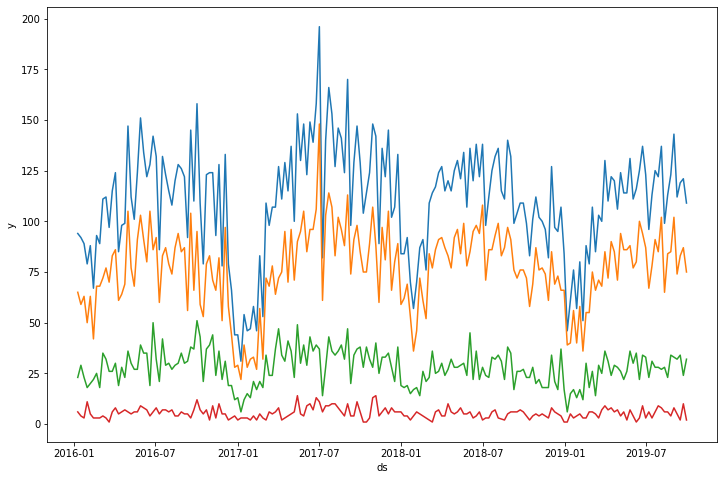

In [8]:

master_day_data=day_split_count(master)
sfr_day_data=day_split_count(sfr_master)
condo_day_data=day_split_count(condo_master)

master_week_data=week_split_count(master)
sfr_week_data=week_split_count(sfr_master)
condo_week_data=week_split_count(condo_master)

master_month_data=time_series_sale_count(master)
sfr_month_data=time_series_sale_count(sfr_master)
condo_month_data=time_series_sale_count(condo_master)


fig,ax=plt.subplots(figsize=(12,8))
ax1=time_plot(week_split_count(master))
ax2=time_plot(week_split_count(sfr_master))
ax3=time_plot(week_split_count(condo_master))
ax4=time_plot(week_split_count(town_master))


# Implement Facebook Prophet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


''

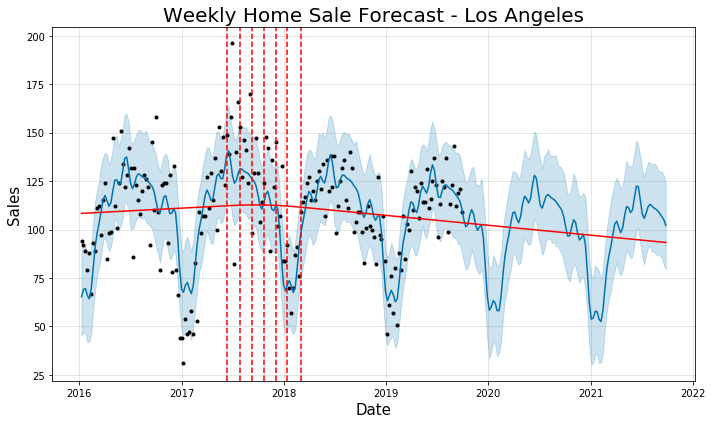

In [9]:
master_model=Prophet()
master_model.fit(master_week_data)
master_future = master_model.make_future_dataframe(periods=104,freq='W')
master_forecast = master_model.predict(master_future)
fig = master_model.plot(master_forecast)
a = add_changepoints_to_plot(fig.gca(),master_model,master_forecast)
plt.title('Weekly Home Sale Forecast - Los Angeles',size=20)
plt.xlabel('Date',size=15)
plt.ylabel('Sales',size=15)
plt.savefig('house_sale_forecast.png')
plt.tight_layout()
;

''

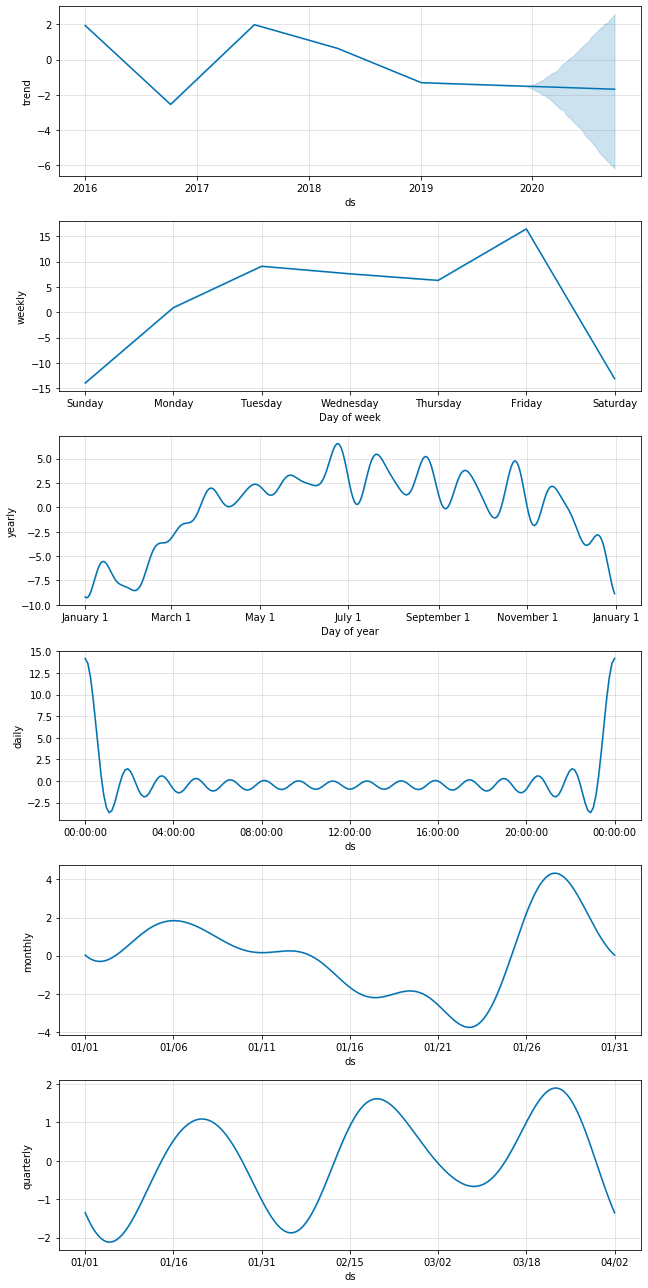

In [10]:
master_model=Prophet(
    growth='linear',
    n_changepoints=4,
    changepoint_range=0.8,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    seasonality_prior_scale=20,
    changepoint_prior_scale=.5,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    ).add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=5
    ).add_seasonality(
        name='daily',
        period=1,
        fourier_order=15
    ).add_seasonality(
        name='weekly',
        period=7,
        fourier_order=20
    ).add_seasonality(
        name='yearly',
        period=365.25,
        fourier_order=20
    ).add_seasonality(
        name='quarterly',
        period=365.25/4,
        fourier_order=5,
        prior_scale=15)
master_model.fit(master_day_data)
master_future = master_model.make_future_dataframe(periods=365)
master_forecast = master_model.predict(master_future)
master_model.plot_components(master_forecast)
;

Test the model by splitting it and comparing the prediction to data the model has not seen yet.

In [11]:
master_week_data.shape[0] # check size of dataframe

195

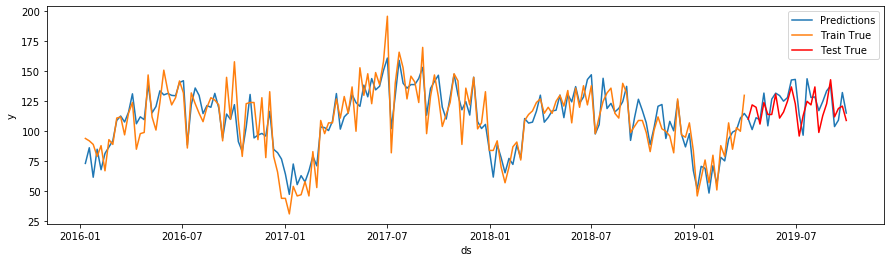

In [12]:
def train_test_split_weekly_analysis(df,split,freq):
    train = df.iloc[:split]
    test = df.iloc[split:]
    # m_eval = Prophet(growth='linear')
    m_eval = Prophet(
        growth='linear',
        n_changepoints=3,
        changepoint_range=0.8,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',
        seasonality_prior_scale=20,
        changepoint_prior_scale=.5,
        mcmc_samples=0,
        interval_width=0.8,
        uncertainty_samples=500,
        ).add_seasonality(
            name='monthly',
            period=30.5,
            fourier_order=5
        ).add_seasonality(
            name='yearly',
            period=365.25,
            fourier_order=20
        ).add_seasonality(
            name='quarterly',
            period=365.25/4,
            fourier_order=5,
            prior_scale=15)
    m_eval.fit(train)
    eval_future=m_eval.make_future_dataframe(periods=test.shape[0],freq=freq)
    eval_forecast=m_eval.predict(eval_future)

    fig,axs=plt.subplots(1,1,figsize=(15,4))
    ax1 = sns.lineplot(x='ds',y='yhat',data=eval_forecast,label='Predictions',legend='full')
    ax1 = sns.lineplot(x='ds',y='y',data=train,label='Train True',legend='full',linestyle='-.')
    ax1 = sns.lineplot(x='ds',y='y',data=test,label='Test True',legend='full',color='red')

split=169 
freq='W'
train_test_split_weekly_analysis(master_week_data,split,freq)

## Analyze residence type

MAPE = 0.0896283317901109
RMSE = 11.931292025474733
MEAN = 110.07179487179488


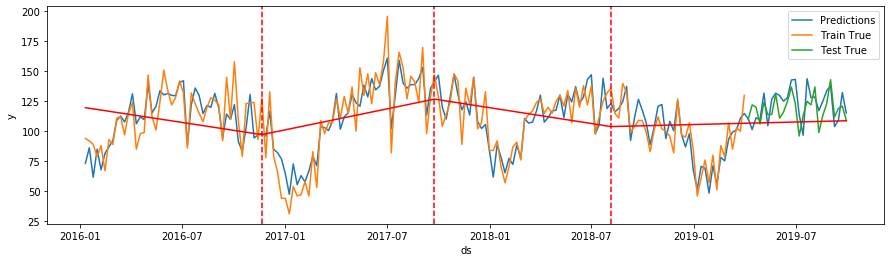

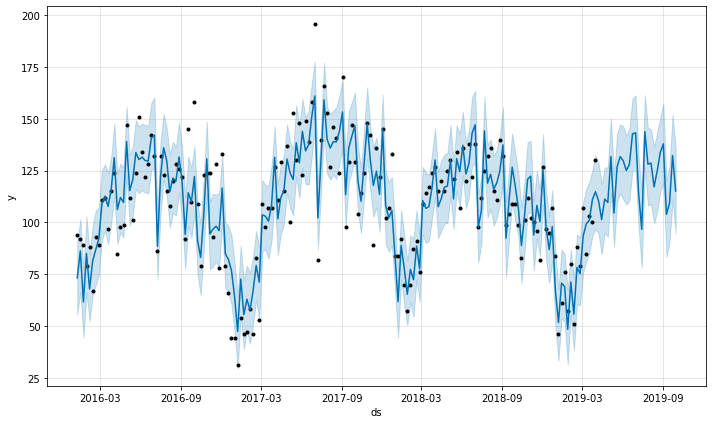

In [13]:
changepoints=3
split=169
freq='W'

prophet_analysis(master_week_data,split,freq,changepoints)

## Analyze residence type: SFR

MAPE = 0.09801855555611838
RMSE = 9.88411782929433
BASE RMSE = 38.30997058409007
MEAN = 76.75897435897436


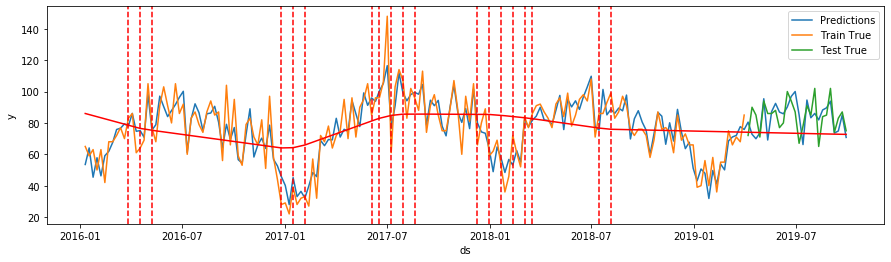

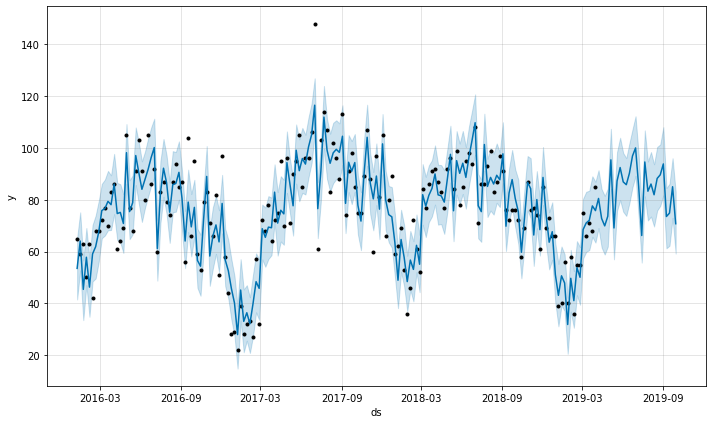

In [14]:
def prophet_analysis(df,split,freq,changepoints=3):
    train = df.iloc[:split]
    test = df.iloc[split:]
    
    naive = master_week_data[117:143]
    
    # m_eval = Prophet(growth='linear')
    m_eval = Prophet(
        growth='linear',
        n_changepoints=changepoints,
        changepoint_range=0.8,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',
        seasonality_prior_scale=20,
        changepoint_prior_scale=.5,
        mcmc_samples=0,
        interval_width=0.8,
        uncertainty_samples=500,
        ).add_seasonality(
            name='monthly',
            period=30.5,
            fourier_order=5
        ).add_seasonality(
            name='yearly',
            period=365.25,
            fourier_order=20
        ).add_seasonality(
            name='quarterly',
            period=365.25/4,
            fourier_order=5,
            prior_scale=15)
    m_eval.fit(train)
    eval_future=m_eval.make_future_dataframe(periods=test.shape[0],freq=freq)
    eval_forecast=m_eval.predict(eval_future)

    fig,axs=plt.subplots(1,1,figsize=(15,4))
    ax1 = sns.lineplot(x='ds',y='yhat',data=eval_forecast,label='Predictions',legend='full')
    ax1 = sns.lineplot(x='ds',y='y',data=train,label='Train True',legend='full',linestyle='-.')
    ax1 = sns.lineplot(x='ds',y='y',data=test,label='Test True',legend='full')
    
    ax =m_eval.plot(eval_forecast)
    ax = add_changepoints_to_plot(fig.gca(),m_eval,eval_forecast)
    
    predictions = eval_forecast.iloc[-test.shape[0]:]['yhat'] #grab predictions to compare with test set
    print('MAPE = ' + str((abs(np.array(test.y)-predictions)/(np.array(test.y))).mean())) 
    print('RMSE = ' + str(rmse(predictions,test['y'])))
    print('BASE RMSE = ' + str(rmse(naive['y'],test['y'])))
    print('MEAN = ' + str(df.y.mean()))
    return

changepoints=48
split=169
freq='W'


prophet_analysis(sfr_week_data,split,freq,changepoints)

In [15]:
def week_split_avg_close_price(df):
    w = df[['CloseDate','ClosePrice']]
    w['week']=pd.to_datetime(w.CloseDate).apply(lambda x: '{}'.format(x.week))
    w['year']=pd.to_datetime(w.CloseDate).apply(lambda x: '{}'.format(x.year))
    ww = w[['week','year']]
    ww.week=ww.week.apply(int)
    ww.year=ww.year.apply(int)
    ww=ww[ww.week!=53]
    ww['enddate'] = ww.apply(lambda row: pd.to_datetime(Week(row.year, row.week, 'iso').enddate()),axis=1)
    w['ds'] = ww['enddate']
    w=w[['ds','ClosePrice']]
    w.rename(columns={'ClosePrice':'y'},inplace=True)
    w=w.groupby('ds').mean()
    w.reset_index(inplace=True)
    w['ds'] = w['ds'].apply(lambda x: pd.to_datetime(x))
    return w

# Weekly average sale price (CITIES)

In [16]:
sm_week_split_avg_close_price = week_split_avg_close_price(sm_data)
bh_week_split_avg_close_price = week_split_avg_close_price(bh_data)
sl_week_split_avg_close_price = week_split_avg_close_price(sl_data)

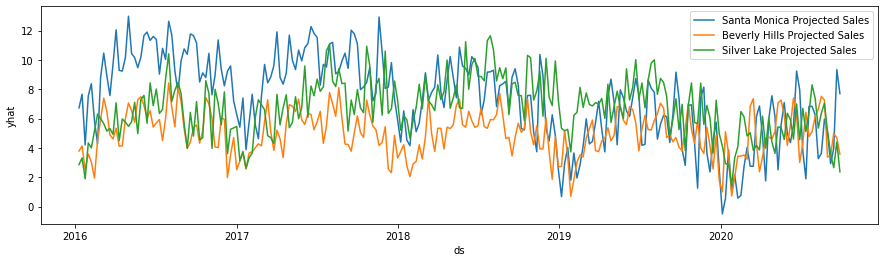

In [19]:
def plot_compare(df1,df2,df3,freq):
    master_model=Prophet(
        growth='linear',
        n_changepoints=3,
        changepoint_range=0.8,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',
        seasonality_prior_scale=20,
        changepoint_prior_scale=.5,
        mcmc_samples=0,
        interval_width=0.8,
        uncertainty_samples=500,
        ).add_seasonality(
            name='monthly',
            period=30.5,
            fourier_order=5
        ).add_seasonality(
            name='yearly',
            period=365.25,
            fourier_order=20
        ).add_seasonality(
            name='quarterly',
            period=365.25/4,
            fourier_order=5,
            prior_scale=15)
    master_model.fit(df1)
    master_future = master_model.make_future_dataframe(periods=52,freq='W')
    master_forecast = master_model.predict(master_future)
    
    sfr_model=Prophet(
        growth='linear',
        n_changepoints=3,
        changepoint_range=0.8,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',
        seasonality_prior_scale=20,
        changepoint_prior_scale=.5,
        mcmc_samples=0,
        interval_width=0.8,
        uncertainty_samples=500,
        ).add_seasonality(
            name='monthly',
            period=30.5,
            fourier_order=5
        ).add_seasonality(
            name='yearly',
            period=365.25,
            fourier_order=20
        ).add_seasonality(
            name='quarterly',
            period=365.25/4,
            fourier_order=5,
            prior_scale=15)
    sfr_model.fit(df2)
    sfr_future = sfr_model.make_future_dataframe(periods=52,freq='W')
    sfr_forecast = sfr_model.predict(sfr_future)
    
    third_model=Prophet(
        growth='linear',
        n_changepoints=3,
        changepoint_range=0.8,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',
        seasonality_prior_scale=20,
        changepoint_prior_scale=.5,
        mcmc_samples=0,
        interval_width=0.8,
        uncertainty_samples=500,
        ).add_seasonality(
            name='monthly',
            period=30.5,
            fourier_order=5
        ).add_seasonality(
            name='yearly',
            period=365.25,
            fourier_order=20
        ).add_seasonality(
            name='quarterly',
            period=365.25/4,
            fourier_order=5,
            prior_scale=15)
    third_model.fit(df3)
    third_future = third_model.make_future_dataframe(periods=52,freq='W')
    third_forecast = third_model.predict(third_future)
    
#     sfr_eval = Prophet(growth='linear')
#     sfr_eval.fit(df)
#     sfr_eval_future=sfr_eval.make_future_dataframe(periods=52,freq=freq)
#     sfr_eval_forecast=sfr_eval.predict(sfr_eval_future)
    
    fig,axs=plt.subplots(1,1,figsize=(15,4))
    ax1 = sns.lineplot(x='ds',y='yhat',data=master_forecast,label='Santa Monica Projected Sales',legend='full')
    ax1 = sns.lineplot(x='ds',y='yhat',data=sfr_forecast,label='Beverly Hills Projected Sales',legend='full')
    ax1 = sns.lineplot(x='ds',y='yhat',data=third_forecast,label='Silver Lake Projected Sales',legend='full')
#     ax1.set_xlim([pd.Timestamp('2019-09-01'),pd.Timestamp('2019-09-30')])
    
split=169
freq='W'
plot_compare(sm_count_weekly_data,bh_count_weekly_data,sl_count_weekly_data,freq)

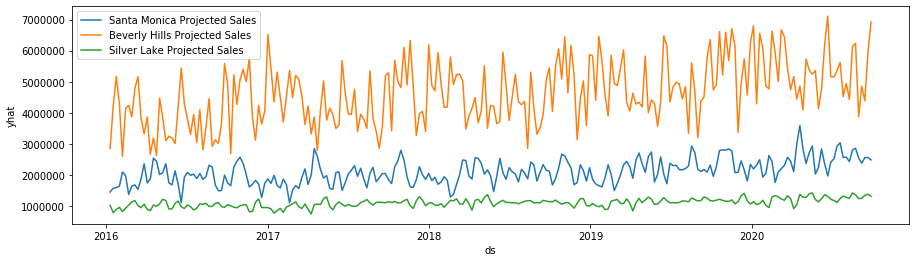

In [20]:
def plot_compare(df1,df2,df3,freq):
    master_model=Prophet(
        growth='linear',
        n_changepoints=3,
        changepoint_range=0.8,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',
        seasonality_prior_scale=20,
        changepoint_prior_scale=.5,
        mcmc_samples=0,
        interval_width=0.8,
        uncertainty_samples=500,
        ).add_seasonality(
            name='monthly',
            period=30.5,
            fourier_order=5
        ).add_seasonality(
            name='yearly',
            period=365.25,
            fourier_order=20
        ).add_seasonality(
            name='quarterly',
            period=365.25/4,
            fourier_order=5,
            prior_scale=15)
    master_model.fit(df1)
    master_future = master_model.make_future_dataframe(periods=52,freq='W')
    master_forecast = master_model.predict(master_future)
    
    sfr_model=Prophet(
        growth='linear',
        n_changepoints=3,
        changepoint_range=0.8,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',
        seasonality_prior_scale=20,
        changepoint_prior_scale=.5,
        mcmc_samples=0,
        interval_width=0.8,
        uncertainty_samples=500,
        ).add_seasonality(
            name='monthly',
            period=30.5,
            fourier_order=5
        ).add_seasonality(
            name='yearly',
            period=365.25,
            fourier_order=20
        ).add_seasonality(
            name='quarterly',
            period=365.25/4,
            fourier_order=5,
            prior_scale=15)
    sfr_model.fit(df2)
    sfr_future = sfr_model.make_future_dataframe(periods=52,freq='W')
    sfr_forecast = sfr_model.predict(sfr_future)
    
    third_model=Prophet(
        growth='linear',
        n_changepoints=3,
        changepoint_range=0.8,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',
        seasonality_prior_scale=20,
        changepoint_prior_scale=.5,
        mcmc_samples=0,
        interval_width=0.8,
        uncertainty_samples=500,
        ).add_seasonality(
            name='monthly',
            period=30.5,
            fourier_order=5
        ).add_seasonality(
            name='yearly',
            period=365.25,
            fourier_order=20
        ).add_seasonality(
            name='quarterly',
            period=365.25/4,
            fourier_order=5,
            prior_scale=15)
    third_model.fit(df3)
    third_future = third_model.make_future_dataframe(periods=52,freq='W')
    third_forecast = third_model.predict(third_future)
    
    
    fig,axs=plt.subplots(1,1,figsize=(15,4))
    ax1 = sns.lineplot(x='ds',y='yhat',data=master_forecast,label='Santa Monica Projected Sales',legend='full')
    ax1 = sns.lineplot(x='ds',y='yhat',data=sfr_forecast,label='Beverly Hills Projected Sales',legend='full')
    ax1 = sns.lineplot(x='ds',y='yhat',data=third_forecast,label='Silver Lake Projected Sales',legend='full')
#     ax1.set_xlim([pd.Timestamp('2019-09-01'),pd.Timestamp('2019-09-30')])
    
split=169
freq='W'
plot_compare(sm_week_split_avg_close_price,bh_week_split_avg_close_price,sl_week_split_avg_close_price,freq)

## CV

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [ ]:
def prophet_analysis(df,split,freq,changepoints=3):
    train = df.iloc[:split]
    test = df.iloc[split:]
    
    naive = master_week_data[117:143]
    
    # m_eval = Prophet(growth='linear')
    m_eval = Prophet(
        growth='linear',
        n_changepoints=changepoints,
        changepoint_range=0.8,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',
        seasonality_prior_scale=20,
        changepoint_prior_scale=.5,
        mcmc_samples=0,
        interval_width=0.8,
        uncertainty_samples=500,
        ).add_seasonality(
            name='monthly',
            period=30.5,
            fourier_order=5
        ).add_seasonality(
            name='yearly',
            period=365.25,
            fourier_order=20
        ).add_seasonality(
            name='quarterly',
            period=365.25/4,
            fourier_order=5,
            prior_scale=15)
    m_eval.fit(train)
    eval_future=m_eval.make_future_dataframe(periods=test.shape[0],freq=freq)
    eval_forecast=m_eval.predict(eval_future)

    # Initial
    initial = 1 * 365
    initial = str(initial) + ' days'

    # Period
    period = 1 * 90
    period = str(period) + ' days'

    # Horizon
    horizon = 180
    horizon = str(horizon) + ' days'
    changepoints=48
    split=169
    freq='W'
    
    df_cv = cross_validation(m_eval,initial=initial,period=period,horizon=horizon)

